# Local Voting Behavior - In depth Analysis (Machine Learning)
A friend of mine running for the local council has procured the voter registration data for the area and shared it with me. With a view to helping them campaign effectively and efficiently I have investigated and analyzed the voter characteristics and how these can be used to predict who to focus campaigning efforts on.

Having cleaned and prepared my data in earlier related notebooks I now set out to create a model that can be used to identify the likely voting habits of voters and hence be used by my friend to target marketing and outreach efforts.

Needing a binary prediction output of either 'will' vote or 'wont' vote I chose to explore two different models, a random forest and a logistic regression. Following initial results I noted that the random forest seemed to be providing better results and used a grid search and visual optimization techniques to tune the model further.

## Initial data reshaping.

The clean data is organized by voter with one voter and data on up to 6 elections per row. For modeling I wanted each row to relate to a unique election and for predicting future election we needed to extend the data to cover the 2018 elections.

In [1]:
# imports and loading clean data
import pandas as pd
import numpy as np
#import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
from modules.lv_utils import load_households, load_voters

# load the data
households = load_households('data_clean/20180725_fullset_households_district3.csv')
voters = load_voters('data_clean/20180725_fullset_voters_district3.csv')
elections = pd.read_csv('data_clean/20180621_election_data.csv')

In [2]:
#full list of colums with potential features relating to individual elections
data_cols = ['Abbr', 'Precinct', 'PrecinctSub', 'Party', 'PartyMain',
       'RegDate', 'PAV', 'RegDateOriginal','VScorePct', 'nVScorePctInHH', 'BirthYear',
       'OldestInHouseBirthYear', 'IsOldestInHouse', 'havePhone',
       'BirthPlaceState', 'BirthPlaceStateRegion', 'BirthPlaceCountry',
       'BirthPlaceCountryRegion', 'Gender', 'sameMailAddress', 'MailCountry',
       'isApt', 'Zip', 'StreetType', 'EmailProvider','nVotersInHH', 'PAVCode', 'nPAVInHH',
       'HasParty', 'nAffInHH', 'isDEM', 'isREP', 'isNPP', 'nDEMInHH',
       'nREPInHH', 'nNPPInHH', 'CityArea', 'mostAfflsInHH', 'mixedAfflsInHH',
       'allAffInHH', 'uniformAffInHH']

# columns that relate to specific elections
e_cols = ['E6_110816', 'E5_060716','E4_110414', 'E3_060314', 'E2_110612', 'E1_060512']
gdt_cols = ['E1_GndTth', 'E2_GndTth', 'E3_GndTth', 'E4_GndTth','E5_GndTth', 'E6_GndTth']
# individual election vote rate
nvp_cols = ['E6_nVotesPct','E5_nVotesPct','E4_nVotesPct','E3_nVotesPct','E2_nVotesPct','E1_nVotesPct']
nvphh_cols = ['E1_nVotesPctInHH', 'E2_nVotesPctInHH', 'E3_nVotesPctInHH',
              'E4_nVotesPctInHH', 'E5_nVotesPctInHH', 'E6_nVotesPctInHH']
# Previous cycle vote rate
cv_cols = ['E12_nVotesPct', 'E14_nVotesPct', 'E16_nVotesPct']
cvhh_cols = ['E12_nVotesPctInHH','E14_nVotesPctInHH','E16_nVotesPctInHH']

# cumulative - executed in 20_Modeling_Report
#cv_cols = ['E34_nVotesPct', 'E56_nVotesPct', 'E78_nVotesPct']
#cvhh_cols = ['E34_nVotesPctInHH','E56_nVotesPctInHH','E78_nVotesPctInHH']

# Make all series start with E1 (ie turning a series around where required:)
e_cols = e_cols[::-1]
nvp_cols = nvp_cols[::-1]

In [3]:
# all election related columns
cols = e_cols + gdt_cols + nvp_cols + nvphh_cols + cv_cols + cvhh_cols
# working data frame, data columns and election related columns
dfw = voters.loc[:,cols + data_cols]

In [4]:
# gathering each set of data ready for reshaping and joining
ele = ['E1','E2','E3','E4','E5','E6','E7','E8']
dfw_data = dfw.drop(columns=cols)
dfw_data.index.rename('vid', inplace=True)

dfw_elecs = dfw[e_cols].replace(r'', np.nan)
dfw_elecs.index.rename('vid', inplace=True)
dfw_elecs.columns = ele[:6]
dfw_elecs = dfw_elecs.join(pd.DataFrame(np.nan, index=dfw_elecs.index, columns=['E7','E8']))

dfw_gdt = dfw[gdt_cols]
dfw_gdt.index.rename('vid', inplace=True)
dfw_gdt.columns = ele[:6]

dfw_nvp = dfw[nvp_cols]
dfw_nvp.index.rename('vid', inplace=True)
dfw_nvp.columns = ele[1:7]

dfw_nvphh = dfw[nvphh_cols]
dfw_nvphh.index.rename('vid', inplace=True)
dfw_nvphh.columns = ele[1:7]

dfw_cv = dfw[list(np.repeat(cv_cols,2))]
dfw_cv.index.rename('vid', inplace=True)
dfw_cv.columns = ele[2:8]

dfw_cvhh = dfw[list(np.repeat(cvhh_cols,2))]
dfw_cvhh.index.rename('vid', inplace=True)
dfw_cvhh.columns = ele[2:8]

#display(dfw_nvp)

In [5]:
# unstacking each set of data
ustk_e = pd.DataFrame(dfw_elecs.unstack(level=1))
ustk_e.columns = ['vote']
ustk_g = pd.DataFrame(dfw_gdt.unstack(level=1))
ustk_g.columns = ['gndtth']
ustk_l = pd.DataFrame(dfw_nvp.unstack(level=1))
ustk_l.columns = ['lastElecVoteRate']
ustk_lhh = pd.DataFrame(dfw_nvphh.unstack(level=1))
ustk_lhh.columns = ['lastElecVoteRatehh']
ustk_r = pd.DataFrame(dfw_cv.unstack(level=1))
ustk_r.columns = ['lastCycleVoteRate']
ustk_rhh = pd.DataFrame(dfw_cvhh.unstack(level=1))
ustk_rhh.columns = ['lastCycleVoteRatehh']

# Combining the various reshaped election tables and the person data, filling na with -1
data = ustk_e.join([ustk_g, ustk_l, ustk_lhh, ustk_r, ustk_rhh]).fillna(-1)\
            .join(dfw_data).reorder_levels([1,0]).sort_index(level=0)
data.index.levels[1].name = 'e'

In [6]:
# adding in features about the election themselves
elections.index = ele[::-1]
elections.index.name = 'e'
elections

,elections,dates,cycle,etype,president,us_senate_maj,us_repre_maj,ca_governor,ca_lt_govnor,ca_senate_maj,ca_assembly_maj
e,,,,,,,,,,,
E8,E8_110618,2018-11-06,Cong,General,REP,4,42,DEM,DEM,-13,-28
E7,E7_060518,2018-06-05,Cong,Primary,REP,4,42,DEM,DEM,-13,-28
E6,E6_110816,2016-11-08,Pres,General,DEM,10,60,DEM,DEM,-13,-24
E5,E5_060716,2016-06-07,Pres,Primary,DEM,10,58,DEM,DEM,-13,-24
E4,E4_110414,2014-11-04,Cong,General,DEM,-8,34,DEM,DEM,-13,-31
E3,E3_060314,2014-06-03,Cong,Primary,DEM,-8,34,DEM,DEM,-13,-31
E2,E2_110612,2012-11-06,Pres,General,DEM,-3,50,DEM,DEM,-11,-25
E1,E1_060512,2012-06-05,Pres,Primary,DEM,-3,52,DEM,DEM,-11,-25


In [7]:
data = data.join(elections)
data = data.drop(columns=['elections','dates'])  # duplicated information

In [8]:
print('The final shape of the data ready for modeling is {} rows, and {} columns'.format(data.shape[0],data.shape[1]))
data.iloc[:16,:5+50:]

The final shape of the data ready for modeling is 106456 rows, and 56 columns


vote  gndtth  lastElecVoteRate  lastElecVoteRatehh  lastCycleVoteRate  \
vid e                                                                          
0   E1    V     1.0              -1.0                -1.0               -1.0   
    E2    V     1.0               1.0                 1.0               -1.0   
    E3    V     1.0               1.0                 1.0                1.0   
    E4    V     1.0               1.0                 1.0                1.0   
    E5    A     1.0               1.0                 1.0                1.0   
    E6    A     1.0               1.0                 1.0                1.0   
    E7   -1    -1.0               1.0                 1.0                1.0   
    E8   -1    -1.0              -1.0                -1.0                1.0   
1   E1   -1    -1.0              -1.0                -1.0               -1.0   
    E2    V     1.0              -1.0                -1.0               -1.0   
    E3    N     0.0               1.0                 1.0                1.0   
    E4    V     1.0               0.0                 0.0                1.0   
    E5    A     1.0               1.0                 0.5                0.5   
    E6    A     1.0               1.0                 0.5                0.5   
    E7   -1    -1.0               1.0                 0.8                1.0   
    E8   -1    -1.0              -1.0                -1.0                1.0   

        lastCycleVoteRatehh  Abbr  Precinct  PrecinctSub Party      ...        \
vid e                                                               ...         
0   E1            -1.000000    82    832400            0   DEM      ...         
    E2            -1.000000    82    832400            0   DEM      ...         
    E3             1.000000    82    832400            0   DEM      ...         
    E4             1.000000    82    832400            0   DEM      ...         
    E5             1.000000    82    832400            0   DEM      ...         
    E6             1.000000    82    832400            0   DEM      ...         
    E7             1.000000    82    832400            0   DEM      ...         
    E8             1.000000    82    832400            0   DEM      ...         
1   E1            -1.000000    82    832910            0   DEM      ...         
    E2            -1.000000    82    832910            0   DEM      ...         
    E3             1.000000    82    832910            0   DEM      ...         
    E4             1.000000    82    832910            0   DEM      ...         
    E5             0.250000    82    832910            0   DEM      ...         
    E6             0.250000    82    832910            0   DEM      ...         
    E7             0.666667    82    832910            0   DEM      ...         
    E8             0.666667    82    832910            0   DEM      ...         

       allAffInHH uniformAffInHH cycle    etype  president  us_senate_maj  \
vid e                                                                       
0   E1      False          False  Pres  Primary        DEM             -3   
    E2      False          False  Pres  General        DEM             -3   
    E3      False          False  Cong  Primary        DEM             -8   
    E4      False          False  Cong  General        DEM             -8   
    E5      False          False  Pres  Primary        DEM             10   
    E6      False          False  Pres  General        DEM             10   
    E7      False          False  Cong  Primary        REP              4   
    E8      False          False  Cong  General        REP              4   
1   E1      False          False  Pres  Primary        DEM             -3   
    E2      False          False  Pres  General        DEM             -3   
    E3      False          False  Cong  Primary        DEM             -8   
    E4      False          False  Cong  General        DEM             -8   
    E5      False          Fa

In [9]:
data = data.reset_index()
print('one row for each of our votes for each election')
display(data.e.value_counts())

one row for each of our votes for each election


E6    13307
E3    13307
E7    13307
E4    13307
E8    13307
E5    13307
E2    13307
E1    13307
Name: e, dtype: int64

## Exploring the data for correlation and variation

I want to check that the data still looks how I expect with the correlations we saw in earlier analysis. I also wanted to see how balanced my vote and no vote classes are.

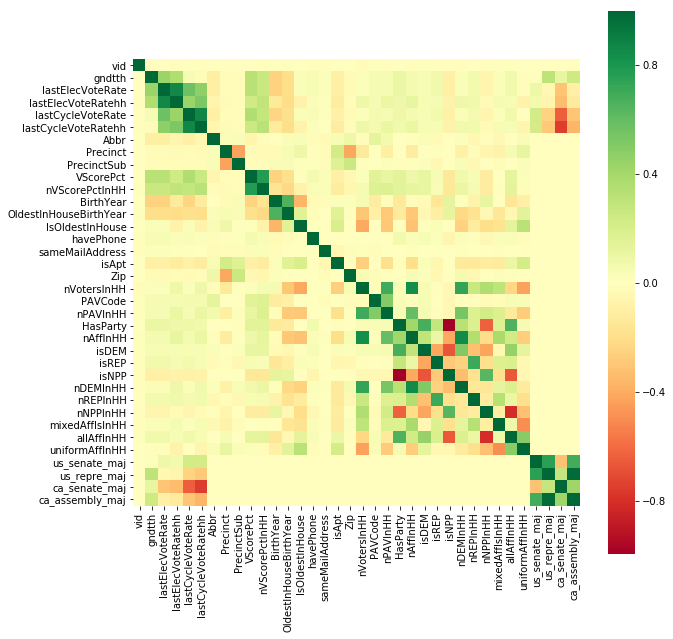

In [10]:
plt.rcParams["figure.figsize"] = (10,10)

# explore the data with a heat map
sns.heatmap(data.corr(), square=True, cmap='RdYlGn')
plt.show()

In [11]:
# looking at how balanced our classes are:
# An Absentee vote is 'A', an in person vote is 'V' and a registered voter who doesn't vote is an 'N'
# anyone not registered at the time of the election in question is a -1.
print(data.vote.value_counts())
print(data.gndtth.value_counts())

-1    45426
N     30329
A     19762
V     10939
Name: vote, dtype: int64
-1.0    45426
 1.0    30701
 0.0    30329
Name: gndtth, dtype: int64


My over all data is very balanced between voting and not voting classes. This will make using various modeling techniques easier.

## Now we have our full data - check for variance

Given that we have cut our data set down it makes sense to check for and then remove any column that now doesn't carry actual information into the model - ie the column value happens to be the same for all elections in the data to be modeled.

2 columns ended up being removed at this stage.

In [12]:
# variance check - removing 4 columns that don't change across 'E3','E4','E5','E6' as they don't carry any information
print(data.shape)
print(data.loc[:,data.apply(pd.Series.nunique) == 1].columns)
data = data.loc[:,data.apply(pd.Series.nunique) != 1]
print(data.shape)

(106456, 58)
Index(['ca_governor', 'ca_lt_govnor'], dtype='object')
(106456, 56)


## Turning categorical data into one hot encoded data

In order for a most model to work well (including the random forest model I plan to use) we need to encode each item of data into a single column - columns containing multiple categories can not be processed directly, the get_dummies method handles the required encoding splitting each category into its own binary encoded column. 

Many models including Random Forest's also can't directly use datetime data this type of data instead needs to be encoded into engineered features eg 'day of month' or 'before/after' an event or day. In this case its not clear that the datetime columns 'RegDate' and 'RegDateOriginal' will carry any valuable data that isn't already captures or more directly captured by birthyear and other already columns so rather than engineering further I chose to drop these columns.

In [13]:
# Object and category columns for get_dummies
cat_cols = data.select_dtypes(exclude=["number", "bool_", "datetime"]).columns
# We only want to act on the feature data so dropping the election and vote label columns from cat_cols
cat_cols = cat_cols.drop(['e','vote'])
# Datetime columns for removal
dt_cols = data.select_dtypes(exclude=["number", "bool_", "object_", "category"]).columns

In [14]:
df_d = pd.get_dummies(data=data, columns=cat_cols)
df_d = df_d.drop(columns=dt_cols)

## Removing NaNs (aka -1's) for training and model development

There are also a lot of rows for elections where the voter wasn't registered for a particular election - this includes this years elections where we don't know the voters registration and vote status, these will be removed for the model training so as to present a clean two state classification problem.

In [15]:
# removing all rows where voter wasn't registered ie the -1's or nulls in the data set
# this will also remove all E7 &E8 rows
print(df_d.shape)
data_bin = df_d[df_d.gndtth != -1]
data_bin.shape

(106456, 530)


(61030, 530)

# Initial Random Forest Model

As my data is looking for binary classification - will vote/won't vote I decided to try using a random forest supervised machine learning model first. These models are well known for performing well on many different data sets as they are easy to use and often produces a great result, sometimes without hyper-parameter tuning. They are also ideal for classification tasks (although it can be used for regression also). Here is a [blog by Ahmed El Deeb](https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883) that expands on this topic.

Given that my data doesn't have Last Election and Last Election Cycle information for the elections held in 2012, I'm going to build my models using the 4 elections we do have complete data for. The additional vote data could be procured if we were motivated and willing to make the additional investment so doesn't impact of the validity of the model. 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
df = data_bin[data_bin.e.isin(['E3','E4','E5','E6'])]
print(df.shape)

(43157, 530)


In [18]:
# features for model
X = df.drop(columns=['vid','vote','e','gndtth'])
# ground Truth for model training
y = df.gndtth

In [19]:
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [20]:
model = RandomForestClassifier(random_state=42)
model = model.fit(Xtrain, ytrain)

In [21]:
print(accuracy_score(ytest, model.predict(Xtest)))

0.9054680259499537


Out of the box the sklearn Random Forest model has given us a $90.5\%$ accuracy - Not bad, but does the model have a feature that is 'leaking' data - or in other words a feature that couldn't actually be created for future elections as it captures the voter behavior out come somehow in its variance?

We can answer that by looking at the feature importance and noting is any particular feature is driving an unreasonable amount of model predictability.

In [22]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance'])\
                                        .sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
VScorePct,0.202490
nVScorePctInHH,0.134275
us_repre_maj,0.042719
lastCycleVoteRatehh,0.040229
lastElecVoteRate,0.039531
lastElecVoteRatehh,0.037942
etype_Primary,0.034404
BirthYear,0.028919
lastCycleVoteRate,0.027851
OldestInHouseBirthYear,0.026430


This model is looking good - there are a number of features each helping predict voter behavior and they are the features we would expect based on the statistical analysis completed earlier eg your birth year. 

There are a couple of interesting points to note:
* The top features are the ones my friend engineered into the data based on a weighted combination of which elections someone had voted in considering which they were available for.
* The us_repre_maj or size of the majority in the US house of Representatives is a surprisingly important feature in this particular set of data - this may or not hold more broadly as the republican's holding power may be unusually motivating in this Californian left leaning district.
* The next set of important features are your Vote Rates in the last election cycle and the type of election 
* As expected BirthYear and whether you are the Oldest in your household make up the rest of the top ten features.


I tried removing my friends engineered features and as you would expect given their importance the models accuracy dropped significantly.

In [23]:
# removing my friends engineered features and running the model again
X = df.drop(columns=['vid','vote','e','gndtth', 'VScorePct', 'nVScorePctInHH'])
y = df.gndtth
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=5)
model_no_VScore = RandomForestClassifier(random_state=42)
model_no_VScore = model_no_VScore.fit(Xtrain,ytrain)
print(accuracy_score(ytest, model_no_VScore.predict(Xtest)))

0.7695088044485635


## Tuning the Random Forest

Even though we have a nicely performing model I wanted to see how much better it would get with a bit of tuning.

The default values for sklearns RandomForestClassifier leads to fully grown unpruned trees - also very large amounts of memory gets used!

Below I complete a grid search also using 5 fold cross validation on the key Random Forest parameters, 
* n_estimators, the number of trees grown, 
* max_features, the number of features considered when looking for the best split
* max_depth, max depth (aka number of splits) in each tree
* min_samples_split, the min number of samples required to split an internal node
* min_samples_leaf, the number of samples required to be at a leaf node 

In [24]:
# Resetting the data
X = df.drop(columns=['vid','vote','e','gndtth'])
y = df.gndtth
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [2**x for x in range(2,7)]+[int(x) for x in np.linspace(start = 100, stop = 700, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

{'n_estimators': [4, 8, 16, 32, 64, 100, 250, 400, 550, 700],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, 60, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  RandomForestClassifier(random_state=42)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total= 1.1min
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total= 1.1min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True 
[C

[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   9.2s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.4min


[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=  10.4s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=550, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False, total= 1.2min
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=550, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False, total= 1.2min
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   9.7s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=40, bootstrap=True 
[CV]  n_estimators=16,

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=50, bootstrap=False, total= 1.5min
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False, total=   8.8s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=50, bootstrap=False, total= 1.5min
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False, total=   8.7s
[CV] n_estimators=16, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=16,

[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True, total=  19.6s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=40, bootstrap=True, total= 3.9min
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True, total=  19.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False, total=  19.1s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_s

[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=  56.8s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total= 1.0min
[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   9.1s
[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   8.0s
[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 51.6min


[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False, total= 2.4min
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False, total= 2.4min
[CV] n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=None, bootstrap=False, total= 2.4min
[CV] n_estimators=64, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=  18.5s
[CV] n_estimators=64, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=700, 

[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=40, bootstrap=False, total= 1.4min
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=40, bootstrap=False, total= 1.4min
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=True, total= 2.4min
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=True, total= 2.4min
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=True 
[CV]  n_estimators=100, min_sampl

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.8min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.8min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total= 1.8min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total= 3.7min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, m

[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   8.4s
[CV] n_estimators=64, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   8.3s
[CV] n_estimators=64, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   7.6s
[CV] n_estimators=64, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   7.9s
[CV] n_estimators=64, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, bootstrap=True 
[CV]  n_estimators=64, min_samples_split=10,

[CV] n_estimators=4, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True, total=   6.9s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True, total=   7.0s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True, total=   7.0s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=True, total=   6.8s
[CV] n_estimators=4, min_samples_split=10, min_

[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=True, total=   5.6s
[CV] n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=True, total=   5.6s
[CV] n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=10, bootstrap=False, total=  53.4s
[CV] n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, bootstrap=True, total=   5.8s
[CV] n_estimators=550, min_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 121.2min


[CV]  n_estimators=4, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=30, bootstrap=True, total=   5.6s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=30, bootstrap=True, total=   5.5s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=30, bootstrap=True, total=   5.5s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   7.0s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=8, min_samples_spl

[CV]  n_estimators=550, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total= 3.1min
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=550, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total= 3.1min
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   7.4s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   6.4s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=550, min_samples_

[CV] n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, total= 3.1min
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, total= 3.1min
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=16, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   8.9s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=700, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, total= 3.5min
[CV] n_estimators=400, min_sam

[CV] n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True 
[CV]  n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True, total= 1.4min
[CV] n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True 
[CV]  n_estimators=550, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=60, bootstrap=True, total= 1.3min
[CV] n_estimators=64, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=64, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  29.4s
[CV] n_estimators=64, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=64, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=  29.3s
[CV] n_estimators=64, min_sa

[CV] n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False 
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False, total=  25.0s
[CV] n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False 
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False, total=  25.1s
[CV] n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False 
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False, total=  25.0s
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False, total=  21.9s
[CV]  n_estimators=64, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=30, bootstrap=False, total=  21.6s
[CV]  n_estimators=55

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 162.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [4, 8, 16, 32, 64, 100, 250, 400, 550, 700], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [27]:
# looking at which parameters performed the best
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [28]:
print(accuracy_score(ytest, rf_random.predict(Xtest)))

0.9996292863762744


The above predict run on the 'rf_random' model uses the 'best model' which has then been refitted on all the training data so this predict will be over fitting and not a comparible predictor to the accuracy seen above - where I'm only training on one segment of the data.  To get a comparable number I'll create a separate model using the parameters identified by the Cross Validated Search object and train it on only one fold of data in the traditional way.

In [29]:
rf_b = RandomForestClassifier(random_state = 42,
                                 n_estimators = 400,
                                 min_samples_split = 5,
                                 min_samples_leaf = 1,
                                 max_features = 'sqrt',
                                 max_depth = 30,
                                 bootstrap = False)
rf_b = rf_b.fit(Xtrain,ytrain)
print(accuracy_score(ytest, rf_b.predict(Xtest)))

0.9358665430954588


Using the Best Parameters found via grid search we've boosted the model performance a relatively modest $3\%$ going from $90.5\%$ to $93.6\%$.

In [54]:
feature_importances = pd.DataFrame(rf_b.feature_importances_, index = X.columns, columns=['importance'])\
                                        .sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
VScorePct,0.274709
nVScorePctInHH,0.156416
us_repre_maj,0.041736
lastCycleVoteRate,0.038299
lastCycleVoteRatehh,0.037960
lastElecVoteRate,0.034824
etype_General,0.030202
etype_Primary,0.028909
lastElecVoteRatehh,0.027163
BirthYear,0.023113


I tried a few other settings for Max_features, eg None (where all features are considered for each tree). These model gave too higher accuracy on the test data and I conclude are over fitting a common problem for Random Forests. here is one such model:

In [30]:
# building model to explore other max_features
rf = RandomForestClassifier(random_state = 42,
                                 n_estimators = 16,
                                 min_samples_split = 5,
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 max_depth = 60,
                                 bootstrap = True)
rf = rf.fit(Xtrain,ytrain)
print(accuracy_score(ytest, rf.predict(Xtest)))

0.9843373493975903


## Graphically selecting n_estimators or the number or trees using ROC curves

Another way to understand and select the best parameters for your random forest model is by using AUC - ROC curves. These AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curves are a useful way to tell when a classification model is able to distinguish two classes well from each other. They rely on plotting the True Positive Rate against the False Positive Rate. More detail can be found in [this blog post](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

When using ROC curves you need to work with 2 classes or consider each class in turn as a one vs many. We have only two classes so can use directly.

In [31]:
from sklearn.metrics import roc_curve, auc
# Graphically optimizing n_estimators
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300, 500, 700, 900]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=42)
    rf.fit(Xtrain,ytrain)
    
    train_pred = rf.predict(Xtrain)
    false_pos_rate, true_pos_rate, threasholds = roc_curve(ytrain, train_pred)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(Xtest)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(ytest, y_pred)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    test_results.append(roc_auc)

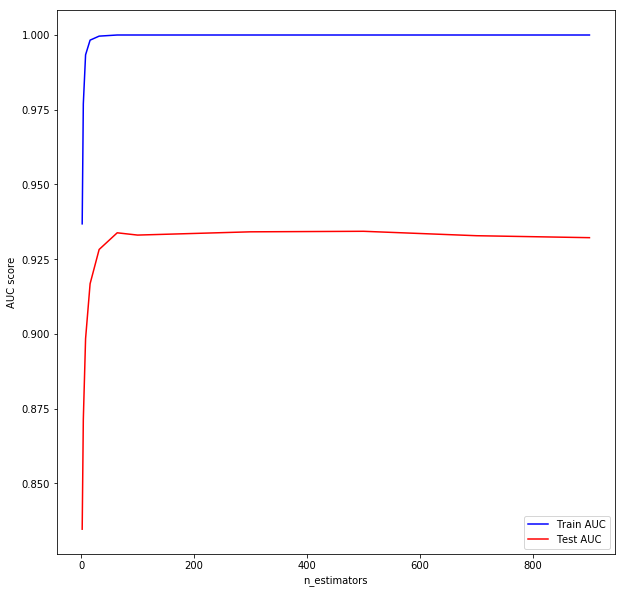

In [32]:
line1 = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2 = plt.plot(n_estimators, test_results, 'r', label='Test AUC')

plt.legend(loc='lower right')

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

This graphical methods allows you to see that gains in performance are made more quickly at first, so incrementally increasing the number of estimators may lead to small increases in performance but the cost in time taken to train the model and run it during prediction cycles may not justify the small additional accuracy. 

The flatness of these curves after the initial gains are made also explain why there is some variability in the 'best' model parameters when running multiple iterations of the searchCV analysis.

## Graphically selecting Max_depth

Similarly using an AUC - ROC curve can be used to select the best max depth for use in the Random Forest.

In [33]:
# Graphically optimizing max_depth
max_depths = [x for x in range(1,67,2)]
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=42)
    rf.fit(Xtrain,ytrain)
    
    train_pred = rf.predict(Xtrain)
    false_pos_rate, true_pos_rate, threasholds = roc_curve(ytrain, train_pred)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    train_results.append(roc_auc)
    
    y_pred = rf.predict(Xtest)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(ytest, y_pred)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    test_results.append(roc_auc)

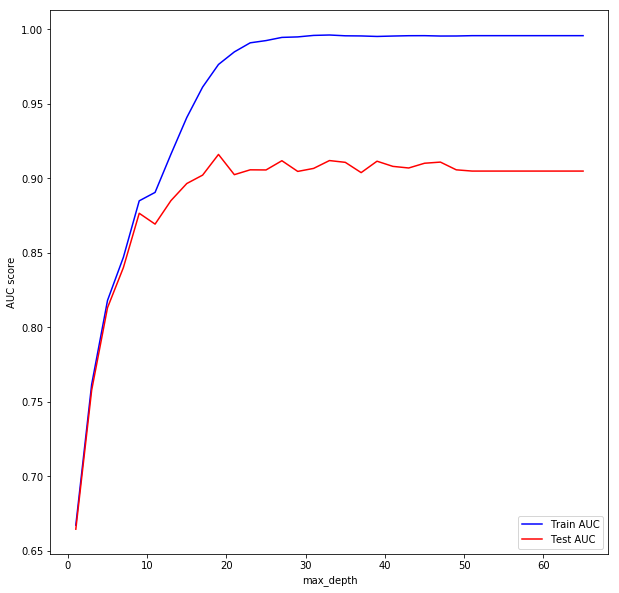

In [34]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2 = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(loc='lower right')

plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

Similarly to n_estimators most benefit to increasing max_depth is made in the initial increase in size or depth of the trees beyond 10 the performance of the random forest is more variable.

# Trying a second Logistic Regression Model

Logistic Regression models should also be able to be used for a binary classification problem although are likely to be harder to optimize, I wanted to give it and shot and see if this holds for the data set at hand.

In [35]:
# Resetting the data
X = df.drop(columns=['vid','vote','e','gndtth'])
y = df.gndtth
# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=5)

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
lr = LogisticRegression()
lr = lr.fit(Xtrain,ytrain)

In [38]:
print(accuracy_score(ytest, lr.predict(Xtest)))

0.631696014828545


It does appear that out of the box the scikit learn logistic regression model performs significantly less well than the Random Forest, one.

## Tuning the Logistic Regression Model

In [39]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression()

#cv_results = cross_val_score(clf, X, y, cv=KFold(5, random_state=42))
cv_results = cross_val_score(clf, X, y, cv=5)   # if you don't need to pass the random_state
print(cv_results)
np.mean(cv_results)

[0.63195088 0.63322521 0.63167651 0.63318271 0.63074962]


0.6321569881569002

In [40]:
#the grid of parameters to search over
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in Cs:
    lgrg = LogisticRegression(C=c, random_state=20)
    score = cross_val_score(lgrg, X, y, cv=3)
    print('Regularization parameter c: {} had average score: {}'.format(c, score))

Regularization parameter c: 0.001 had average score: [0.63696393 0.62752868 0.6350365 ]
Regularization parameter c: 0.01 had average score: [0.63717245 0.62759819 0.63510601]
Regularization parameter c: 0.1 had average score: [0.63724195 0.62759819 0.6350365 ]
Regularization parameter c: 1 had average score: [0.63724195 0.62759819 0.6350365 ]
Regularization parameter c: 10 had average score: [0.7313547  0.62759819 0.6350365 ]
Regularization parameter c: 100 had average score: [0.63724195 0.62759819 0.63510601]


In [41]:
from sklearn.model_selection import GridSearchCV
# trying some different CV levels
for cv in [3,5,7,10]:
    print("Trying {} folds".format(cv))
    parameters = {'C':Cs}
    gslr = LogisticRegression(random_state=20)
    gsclf = GridSearchCV(gslr, parameters, cv=cv)
    gsclf.fit(X, y)
    print("Best parameter: {}".format(gsclf.best_params_))
    print("Best score: {}".format(gsclf.best_score_))
    print("Test set accuracy: {}".format(accuracy_score(ytest,gsclf.predict(Xtest))))

Trying 3 folds
Best parameter: {'C': 10}
Best score: 0.6646662186898997
Test set accuracy: 0.8185356811862836
Trying 5 folds
Best parameter: {'C': 0.01}
Best score: 0.6781750353360985
Test set accuracy: 0.6320667284522706
Trying 7 folds
Best parameter: {'C': 0.01}
Best score: 0.7044975322659128
Test set accuracy: 0.6320667284522706
Trying 10 folds
Best parameter: {'C': 0.001}
Best score: 0.6640405959635749
Test set accuracy: 0.6451343836886005


From this I conclude that for this data set the random forest is indeed the better model although with further effort a good Logistic regression model could be built.

# Using the model

Having identified a good model I want to use it on E7 and E8 data to predict who is most likely to vote in these two upcoming elections. 

In [42]:
rf_random
# The best fit model was trained on all the data at the end of the RandomizedSearchCV process

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [4, 8, 16, 32, 64, 100, 250, 400, 550, 700], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [43]:
# building optomized model with parameters from Grid Search
rf_b = RandomForestClassifier(random_state = 42,
                                 n_estimators = 400,
                                 min_samples_split = 5,
                                 min_samples_leaf = 1,
                                 max_features = 'sqrt',
                                 max_depth = 30,
                                 bootstrap = False)

In [44]:
# Resetting the data - to create a full training set using all labeled data.
X = df.drop(columns=['vid','vote','e','gndtth'])
y = df.gndtth

In [45]:
# training this 'best fit' model on all the labeled data
rf_b.fit(X,y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [46]:
# Creating the data set that we want to predict votes on
df_p = df_d[df_d.e.isin(['E7','E8'])]
print(df_p.shape)
#display(df_p.head(8))

X = df_p.drop(columns=['vid','vote','e','gndtth'])

(26614, 530)


In [47]:
y_pred = rf_b.predict(X)
y2_pred = rf_random.predict(X)

In [48]:
comp = pd.DataFrame({'rf_b':y_pred, 'rf_random': y2_pred, 'diff': y_pred == y2_pred})
print('The two models dissagree on {} peoples vote'.format(comp.loc[comp['diff']==False].shape[0]))
comp.loc[comp['diff']==False].head()
# both models the one created here and the one from the rf_random run are producing the same results as expected.

The two models dissagree on 0 peoples vote


,rf_b,rf_random,diff


In [49]:
out = pd.concat([df_p, pd.DataFrame(y_pred, columns=['predVote'], index= df_p.index)], axis=1)

In [50]:
out[['vid', 'e', 'predVote', 'VScorePct', 'nVScorePctInHH', 'lastCycleVoteRatehh',
       'lastElecVoteRatehh', 'lastElecVoteRate', 'etype_Primary', 'lastCycleVoteRate', 'BirthYear',
       'OldestInHouseBirthYear', 'etype_General']].head(6)

,vid,e,predVote,VScorePct,nVScorePctInHH,lastCycleVoteRatehh,lastElecVoteRatehh,lastElecVoteRate,etype_Primary,lastCycleVoteRate,BirthYear,OldestInHouseBirthYear,etype_General
6,0,E7,1.0,1.00,1.000000,1.000000,1.0,1.0,1,1.0,1960,1956,0
7,0,E8,1.0,1.00,1.000000,1.000000,-1.0,-1.0,0,1.0,1960,1956,1
14,1,E7,0.0,0.88,0.620899,0.666667,0.8,1.0,1,1.0,1966,1948,0
15,1,E8,1.0,0.88,0.620899,0.666667,-1.0,-1.0,0,1.0,1966,1948,1
22,2,E7,0.0,0.89,0.799911,1.000000,1.0,1.0,1,1.0,1958,1958,0
23,2,E8,1.0,0.89,0.799911,1.000000,-1.0,-1.0,0,1.0,1958,1958,1


In [51]:
out.predVote.value_counts()

0.0    16721
1.0     9893
Name: predVote, dtype: int64

In [52]:
display(out[['vid', 'e', 'predVote']].pivot(index='vid', columns='e', values='predVote').head(6))
print('Counts of predicted votes for E7 and E8:')
out[['vid', 'e', 'predVote']].pivot(index='vid', columns='e', values='predVote').sum(axis=0)

e,E7,E8
vid,,
0,1.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


Counts of predicted votes for E7 and E8:


e
E7    4032.0
E8    5861.0
dtype: float64

In [53]:
all_election_gt = data[['vid', 'e', 'gndtth']].pivot(index='vid', columns='e', values='gndtth')\
                                              .replace(to_replace=-1.0, value=np.nan)
#display(all_election_gt.head(10))
print('Counts of actual votes for E1 through and E6:')
all_election_gt[['E1','E2','E3','E4','E5','E6']].sum(axis=0)

Counts of actual votes for E1 through and E6:


e
E1    2577.0
E2    6937.0
E3    2807.0
E4    4314.0
E5    4846.0
E6    9220.0
dtype: float64

Predicting 4032 votes will be cast in the 2018 primary and 5861 votes in the 2018 general seems reasonable. Particularly if you consider that we should expect the E8 results to be an underestimation as everyone's 'last election' vote will incorrectly be -1 for E8 at this time as we don't have the vote data for E7's election yet. Running the model again between the E7 and E8 elections (ie in July or August 2018) would enable more accurate predictions to be made.

I use the Vid and the previously stored look up table to let my friend know who the likely voters are.